In [6]:
import pandas as pd
import seaborn as sns
from nltk.corpus import stopwords
from collections import  Counter
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
import gensim
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.tokenize import word_tokenize
import pyLDAvis.gensim_models
from wordcloud import WordCloud, STOPWORDS
import nltk
import spacy
import warnings
warnings.filterwarnings('ignore')

import string
import re
import emoji
import contractions

plt.rcParams['figure.figsize'] = (18,9)
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['font.style'] = "oblique"

In [11]:
df = pd.read_fwf('../../datasets/ArcaneS01E01.txt')
df.columns = ['text']
df = df[~df["text"].str.contains("♪")]
df

,text
30,We're almost there.
31,"Aw, man."
32,"Hey, Powder."
33,Come take a look.
34,Whoa.
...,...
584,Feeding time.
585,And the side effects?
586,Stabilizing.
587,You have a subject in mind?


In [12]:
df["text"] = df["text"].apply(lambda x: str(x).replace("\n", " ")
                                                              .replace("\t", " ")
                                                              .replace("\xa0", " ")
                                                              .replace("\r", " ")
                                                              .replace("[", "")
                                                              .replace("]", "")
                                                              .replace("\ufeff", "")
                                                              .replace("\u200b", "")
                                                              .replace("©", "")
                                                              .replace("|", "")
                                                              .replace("#", "")
                                                              .lower()
                                                              .strip())

df['text'] = df['text'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '' , x))

df['text'] = df['text'].apply(lambda x: re.sub('[0-9]', '', x))

df["text"] = df["text"].apply(lambda x: re.sub(' +', ' ', x))


for i in range(len(df)):
    try:
        df.text[i] = emoji.replace_emoji(df.text[i], ' ')
    except:
        pass
    

stop_words = set(stopwords.words('english'))
stop_words.update(['https', 'http', 'com', 'www', 'https://', 
            'http://', 'com/', 'www/', 'width', 'device', 
            'initial', 'scale', 'height', 'px', 'px/', 'px',
            'ie', 'edge', 'chrome', 'firefox', 'safari', 'opera',
            'wi', 'x', 'com', 'website', 'builder', 'telephone', 'skype',
            'toolbar', 'button', 'link', 'image', 'icon', 'icon/',
            'parser', 'compatible', 'fcb', 'ea', 'cf',
            'drop', 'menu', 'de', 'ee', 'ab', 'bb', 'df', 'ff', 'fb', 'eb',
            'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n',
            'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z',
            'html', 'css', 'js', 'json', 'xml', 'json/', 'xml/', 'js/', 'json/',
            'char', 'set', 'utf', 'utf-', 'utf8', 'utf8/', 'utf8', 'utf8/',
            'text', 'minimum', 'maximum', 'length', 'required', 'optional',
            'index', 'nofollow', 'user', 'scalable', 'responsive', 'mobile'])
df['text'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))


lemmatizer = WordNetLemmatizer()
df['text'] = df['text'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))

for i in df.index:
    try:
        df.text[i] = contractions.fix(df.text[i])
    except:
        pass
    
words = set(nltk.corpus.words.words())
for i in df.index:
    df.text[i] = " ".join(w for w in nltk.wordpunct_tokenize(df.text[i]) \
         if w.lower() in words or not w.isalpha())

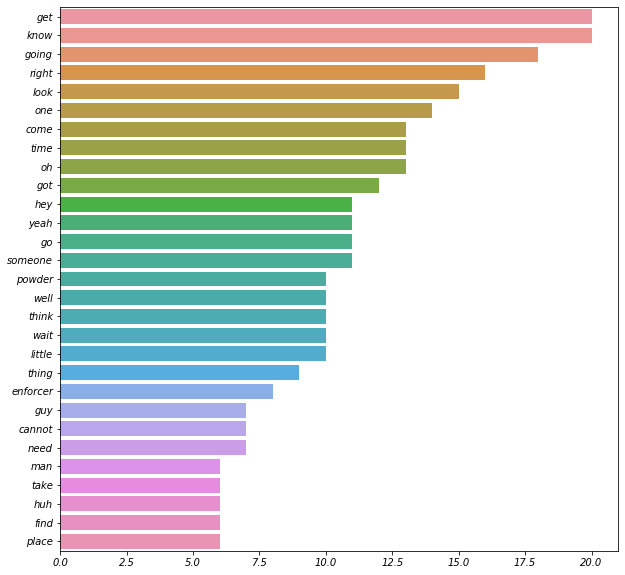

In [13]:
def plot_top_non_stopwords_barchart(text):
    stop=set(stopwords.words('english'))
    
    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    counter=Counter(corpus)
    most=counter.most_common()
    x, y=[], []
    for word,count in most[:40]:
        if (word not in stop):
            x.append(word)
            y.append(count)
            
    plt.figure(figsize=(10,10))
    sns.barplot(x=y,y=x)

plot_top_non_stopwords_barchart(df['text'])

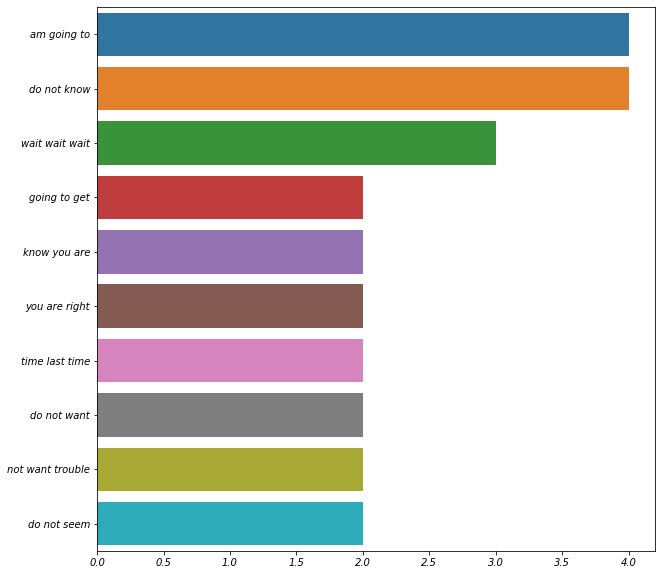

In [14]:
def plot_top_ngrams_barchart(text, n=2):
    stop=set(stopwords.words('english'))

    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    def _get_top_ngram(corpus, n=None):
        vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) 
                      for word, idx in vec.vocabulary_.items()]
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq[:10]

    top_n_bigrams=_get_top_ngram(text,n)[:10]
    x,y=map(list,zip(*top_n_bigrams))
    plt.figure(figsize=(10,10))
    sns.barplot(x=y,y=x)

plot_top_ngrams_barchart(df['text'],3)

In [15]:
def get_lda_objects(text):   
    stop=set(stopwords.words('english'))

    def _preprocess_text(text):
        corpus=[]
        stem=PorterStemmer()
        lem=WordNetLemmatizer()
        for news in text:
            words=[w for w in word_tokenize(news) if (w not in stop)]

            words=[lem.lemmatize(w) for w in words if len(w)>2]

            corpus.append(words)
        return corpus
    
    corpus=_preprocess_text(text)
    
    dic=gensim.corpora.Dictionary(corpus)
    bow_corpus = [dic.doc2bow(doc) for doc in corpus]
    
    lda_model =  gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = 10, 
                                   id2word = dic,                                    
                                   passes = 10,
                                   workers = 2)
    
    return lda_model, bow_corpus, dic

def plot_lda_vis(lda_model, bow_corpus, dic):
    pyLDAvis.enable_notebook()
    vis = pyLDAvis.gensim_models.prepare(lda_model, bow_corpus, dic)
    return vis


lda_model, bow_corpus, dic = get_lda_objects(df['text'])

lda_model.show_topics()

plot_lda_vis(lda_model, bow_corpus, dic)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.137970  0.052778       1        1  13.104988
9      0.142991  0.075088       2        1  11.792613
1      0.063874  0.126238       3        1  10.588303
6     -0.009337 -0.170053       4        1   9.975556
3     -0.149356  0.001957       5        1   9.795452
5      0.111006 -0.087006       6        1   9.220660
4     -0.001892 -0.030869       7        1   9.204529
7     -0.034274  0.089581       8        1   8.939175
8     -0.006945 -0.038830       9        1   8.814335
2      0.021902 -0.018884      10        1   8.564388, topic_info=      Term       Freq      Total Category  logprob  loglift
65    know  13.000000  13.000000  Default  30.0000  30.0000
4     come   9.000000   9.000000  Default  29.0000  29.0000
19     get  14.000000  14.000000  Default  28.0000  28.0000
5     look  10.000000  10.000000  Default  27.0000  27.0000
2      hey   8.000000   8.000000  Default  26.0000  26.0000
..     ...        ...        ...      ...      ...      ...
176   risk   0.761434   2.032621  Topic10  -4.6850   1.4757
178  price   0.761432   2.042458  Topic10  -4.6850   1.4708
415  night   0.761431   2.077019  Topic10  -4.6851   1.4541
285   ever   0.761430   2.042463  Topic10  -4.6851   1.4708
224   good   0.761429   2.695214  Topic10  -4.6851   1.1935

[456 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
358       9  0.738665     academy
446       8  0.743169  accomplice
280       3  0.746032       adult
47        9  0.739140         age
165       3  0.746043      agreed
...     ...       ...         ...
50        3  0.750993        yeah
50        6  0.125165        yeah
50        7  0.125165        yeah
191       4  0.492890     younger
191       8  0.492890     younger

[523 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 10, 2, 7, 4, 6, 5, 8, 9, 3])

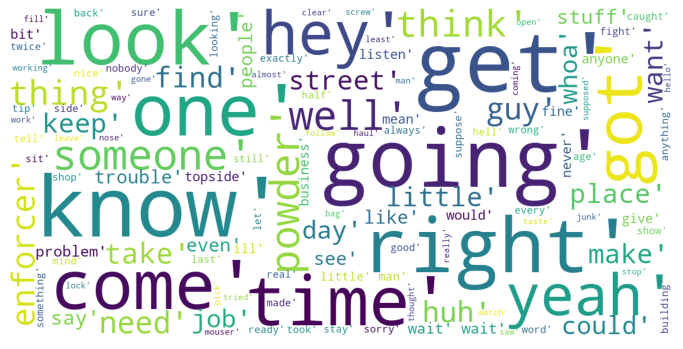

In [16]:
def plot_wordcloud(text):
    stop=set(stopwords.words('english'))

    def _preprocess_text(text):
        corpus=[]
        stem=PorterStemmer()
        lem=WordNetLemmatizer()
        for news in text:
            words=[w for w in word_tokenize(news) if (w not in stop)]

            words=[lem.lemmatize(w) for w in words if len(w)>2]

            corpus.append(words)
        return corpus
    
    corpus=_preprocess_text(text)
    
    wordcloud = WordCloud(
        background_color='white',
        stopwords=set(STOPWORDS),
        max_words=120,
        max_font_size=50, 
        scale=3,
        random_state=1)
    
    wordcloud=wordcloud.generate(str(corpus))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
 
    plt.imshow(wordcloud)
    plt.show()
    
plot_wordcloud(df["text"])